### 1. Import Necessary liibraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
import cv2
import tensorflow as tf 
from tensorflow import keras
from pathlib import Path
import PIL
import os

C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 2. Load the dataset

In [2]:
# import each path of the image classes
glaucoma = Path('dataset/glaucoma')
cataract = Path('dataset/cataract')
normal = Path('dataset/normal')
diabetic_retinopathy = Path('dataset/diabetic_retinopathy')

In [25]:
# create a dataframe with the file path and the labels
disease_type = [glaucoma, cataract,normal,diabetic_retinopathy]
df = pd.DataFrame()
from tqdm import tqdm
for types in disease_type:
    for imagepath in tqdm(list(types.iterdir()), desc= str(types)):
        df = pd.concat([df, pd.DataFrame({'image': [str(imagepath)],'disease_type': [disease_type.index(types)]})], ignore_index=True)

dataset\diabetic_retinopathy: 100%|██████████████████████████████████████████████| 1098/1098 [00:00<00:00, 3634.84it/s]


In [26]:
# display the dataframe
df

,image,disease_type
0,dataset\glaucoma\1020_left.jpg,0
1,dataset\glaucoma\1209_left.jpg,0
2,dataset\glaucoma\1209_right.jpg,0
3,dataset\glaucoma\1210_left.jpg,0
4,dataset\glaucoma\1210_right.jpg,0
...,...,...
4212,dataset\diabetic_retinopathy\129_right.jpeg,3
4213,dataset\diabetic_retinopathy\1302_left.jpeg,3
4214,dataset\diabetic_retinopathy\1302_right.jpeg,3
4215,dataset\diabetic_retinopathy\1305_left.jpeg,3


In [27]:
df.to_csv("data.csv")

In [28]:
# check the count of the target label
df.disease_type.value_counts()

disease_type
3    1098
2    1074
1    1038
0    1007
Name: count, dtype: int64

In [29]:
path=df.iloc[0]['image']
path

'dataset\\glaucoma\\1020_left.jpg'

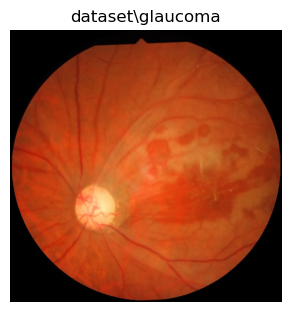

In [30]:
plt.figure(figsize=(12, 12))
img = (plt.imread(path) - plt.imread(path).min()) / plt.imread(path).max()
plt.subplot(3, 3,3)
plt.imshow(img)
plt.axis('off')
plt.title(disease_type[0])

plt.show()

### Visualizing Images in the dataset

In [31]:
# define function to plot sample images
def plot_image(n, num_samples=3):
    disease_labels = ['glaucoma', 'cataract', 'normal', 'diabetic_retinopathy']
    images = df[df['disease_type'] == n].sample(num_samples)['image']
    plt.figure(figsize=(12, 12))

    for i, path in enumerate(images, 1):
        #print(path)

        img = (plt.imread(path) - plt.imread(path).min()) / plt.imread(path).max()
        plt.subplot(3, 3, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(disease_labels[n])

    plt.show()

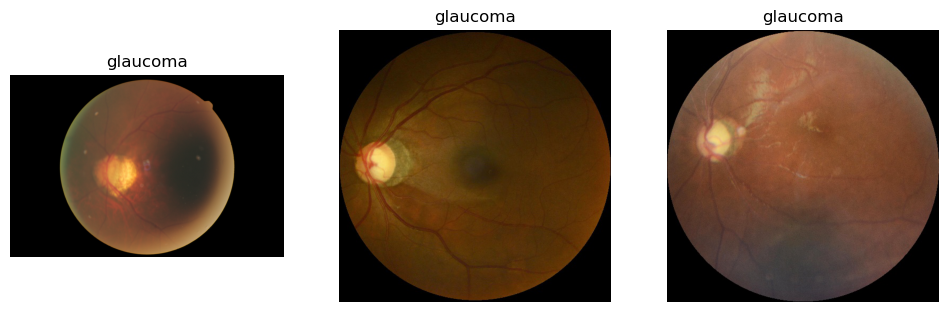

In [32]:
plot_image(0)

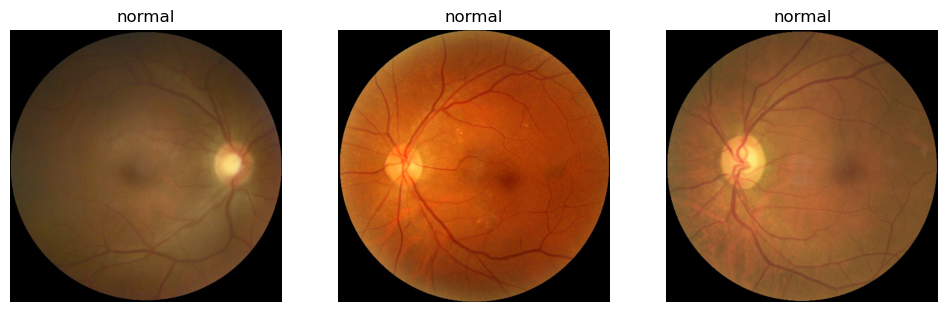

In [33]:
plot_image(2)

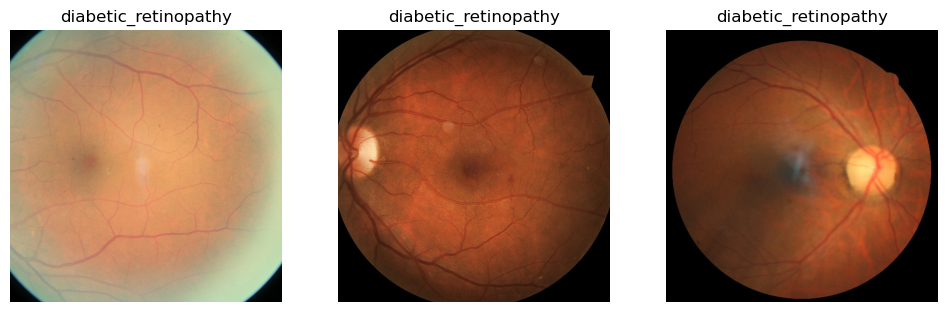

In [34]:
plot_image(3)

In [35]:
# map the labels to the disease type
df['disease_type'] = df['disease_type'].map({0:'glaucoma',1:'cataract',2:'normal',3:'diabetic_retinopathy'})

In [36]:
# check the lebel count to verify it has been mapped
df.disease_type.value_counts()

disease_type
diabetic_retinopathy    1098
normal                  1074
cataract                1038
glaucoma                1007
Name: count, dtype: int64

In [37]:
# randomising the dataset
df1 = df.sample(frac=1).reset_index(drop=True)

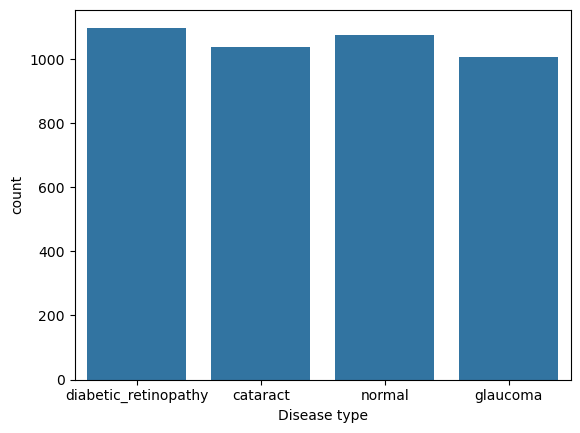

In [38]:
# create a countplot of the disease type
sns.countplot(x = 'disease_type', data = df1)
plt.xlabel("Disease type")
plt.show()

In [39]:
#import necessary libraries for the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix

### Model Training

In [40]:
# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True)
# test_datagen = ImageDataGenerator(rescale=1./255)
# train_generator = train_datagen.flow_from_directory(
#         'data/train',
#         target_size=(150, 150),
#         batch_size=32,
#         class_mode='binary')
# validation_generator = test_datagen.flow_from_directory(
#         'data/validation',
#         target_size=(150, 150),
#         batch_size=32,
#         class_mode='binary')

In [41]:
# augumentation of images
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

In [42]:
# create the train data
train_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = True,
                                          subset = 'training')

Found 3374 validated image filenames belonging to 4 classes.


In [43]:
# create the validation data
valid_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = False,
                                          subset = 'validation')

Found 843 validated image filenames belonging to 4 classes.


In [44]:
# create the validation data
test_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = False,
                                          subset = 'validation')

Found 843 validated image filenames belonging to 4 classes.


In [45]:
labels=[key for key in train_data.class_indices]
num_classes = len(disease_type)

model = keras.Sequential([ 
    layers.Rescaling(1./255, input_shape=(224,224, 3)), 
    layers.Conv2D(128, 3, padding='same', activation='relu'), 
    layers.MaxPooling2D(), 
    layers.Conv2D(64, 3, padding='same', activation='relu'), 
    layers.MaxPooling2D(), 
    layers.Conv2D(32, 3, padding='same', activation='relu'), 
    layers.MaxPooling2D(), 
    layers.Flatten(), 
    layers.Dense(128, activation='relu'), 
    layers.Dense(num_classes,activation='softmax') 
]) 

In [46]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.categorical_crossentropy, 
              metrics=['accuracy']) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        1

In [47]:
# fitting the model
his = model.fit( 
    train_data,
    validation_data=valid_data, 
    epochs=10 
)

Epoch 1/10
  2/106 [..............................] - ETA: 3:37 - loss: 1.4336 - accuracy: 0.2969

KeyboardInterrupt: 

### Visualizing Model Performance

In [31]:
# create a plot of accuracy and val_acuracy for each epoch
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

NameError: name 'his' is not defined

In [ ]:
# create a plot of loss and val_loss for each epoch
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

### Model Evaluation

In [30]:
# evaluate the model
y_test = valid_data.classes
y_pred = model.predict(valid_data)
y_pred = np.argmax(y_pred,axis=1)

27/27 [==============================] - 10s 368ms/step


In [31]:
# generate classification report of the model
print(classification_report(y_test,y_pred,target_names = labels))

                      precision    recall  f1-score   support

            cataract       0.90      0.78      0.83       227
diabetic_retinopathy       0.96      0.98      0.97       225
            glaucoma       0.72      0.72      0.72       193
              normal       0.76      0.86      0.81       198

            accuracy                           0.84       843
           macro avg       0.83      0.83      0.83       843
        weighted avg       0.84      0.84      0.84       843



In [ ]:
model.save("my_model.h5")

# AlexNet

In [51]:
from tensorflow.keras import layers, models

# Создаем модель AlexNet
model = models.Sequential()

# Первый сверточный слой
model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Второй сверточный слой
model.add(layers.Conv2D(256, (5, 5), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Третий сверточный слой
model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

# Четвертый сверточный слой
model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

# Пятый сверточный слой
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Преобразуем в одномерный массив
model.add(layers.Flatten())

# Полносвязные слои
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))

# Выходной слой для классификации
model.add(layers.Dense(num_classes, activation='softmax'))

In [52]:
# Компилируем модель
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Обучаем модель
history = model.fit(train_data, validation_data=valid_data, epochs=10)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 26, 26, 96)       0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 12, 12, 384)       885120    
                                                                 
 conv2d_19 (Conv2D)          (None, 12, 12, 384)      

In [53]:
# Оценка модели на тестовых данных
test_loss, test_acc = model.evaluate(test_data)
print('Test accuracy:', test_acc)

# Генерация предсказаний для тестовых данных
predictions = model.predict(test_data)

27/27 [==============================] - 7s 240ms/step - loss: 0.6662 - accuracy: 0.7509
Test accuracy: 0.7508896589279175
27/27 [==============================] - 7s 248ms/step


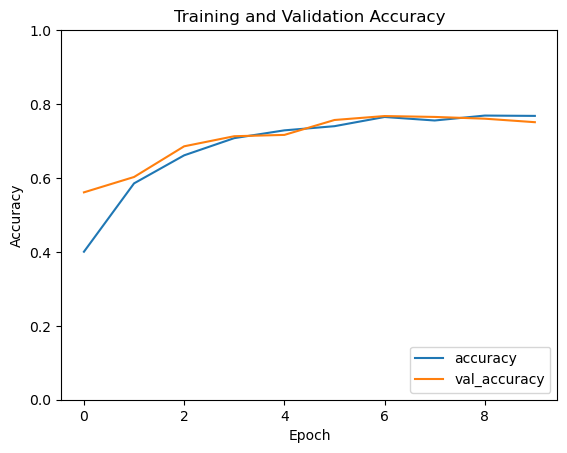

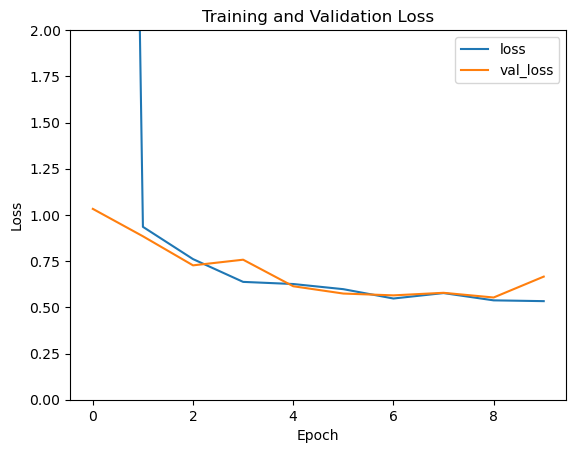

1/1 [==============================] - 0s 233ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


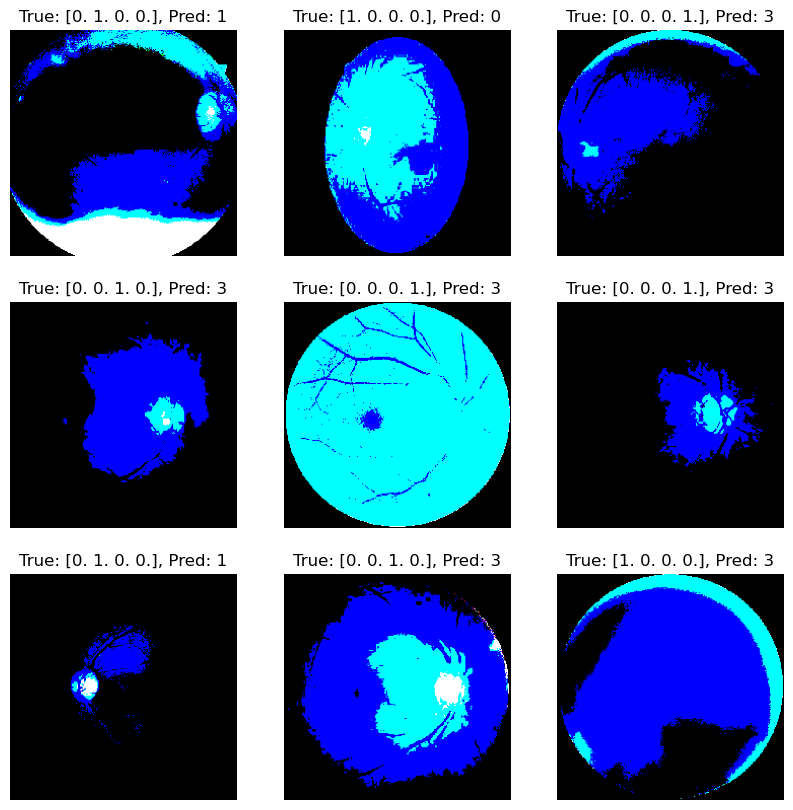

In [54]:
import matplotlib.pyplot as plt

# График точности
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

# График потерь
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Визуализация некоторых изображений и соответствующих предсказаний
import numpy as np

def plot_images(images, labels_true, labels_pred=None):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        if labels_pred is not None:
            plt.title("True: {}, Pred: {}".format(labels_true[i], labels_pred[i]))
        else:
            plt.title("True: {}".format(labels_true[i]))
        plt.axis("off")
    plt.show()

# Получаем несколько изображений и их предсказания
sample_images, true_labels = next(test_data)
predicted_labels = np.argmax(model.predict(sample_images), axis=1)

# Визуализируем изображения
plot_images(sample_images, true_labels, predicted_labels)

# ResNet

In [55]:
from tensorflow.keras import layers, models

# Создаем модель ResNet50
model = models.Sequential()

# Первый сверточный блок
model.add(layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

# Блоки идентичности x3
for _ in range(3):
    model.add(layers.Conv2D(64, (1, 1), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (1, 1), activation='relu', padding='same'))

# Второй сверточный блок
model.add(layers.Conv2D(128, (1, 1), strides=(2, 2), activation='relu', padding='same'))
for _ in range(3):
    model.add(layers.Conv2D(128, (1, 1), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (1, 1), activation='relu', padding='same'))

# Третий сверточный блок
model.add(layers.Conv2D(256, (1, 1), strides=(2, 2), activation='relu', padding='same'))
for _ in range(5):
    model.add(layers.Conv2D(256, (1, 1), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(1024, (1, 1), activation='relu', padding='same'))

# Четвертый сверточный блок
model.add(layers.Conv2D(512, (1, 1), strides=(2, 2), activation='relu', padding='same'))
for _ in range(2):
    model.add(layers.Conv2D(512, (1, 1), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(2048, (1, 1), activation='relu', padding='same'))

# Преобразуем в одномерный массив
model.add(layers.Flatten())

# Полносвязные слои
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dense(2048, activation='relu'))

# Выходной слой для классификации
model.add(layers.Dense(num_classes, activation='softmax'))

In [56]:
# Компилируем модель
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Обучаем модель
history = model.fit(train_data, validation_data=valid_data, epochs=10)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 56, 56, 64)        4160      
                                                                 
 conv2d_23 (Conv2D)          (None, 56, 56, 64)        36928     
                                                                 
 conv2d_24 (Conv2D)          (None, 56, 56, 256)       16640     
                                                                 
 conv2d_25 (Conv2D)          (None, 56, 56, 64)        16448     
                                                      

106/106 [==============================] - 531s 5s/step - loss: 1.3863 - accuracy: 0.2478 - val_loss: 1.3850 - val_accuracy: 0.2550


In [57]:
# Оценка модели на тестовых данных
test_loss, test_acc = model.evaluate(test_data)
print('Test accuracy:', test_acc)

# Генерация предсказаний для тестовых данных
predictions = model.predict(test_data)

27/27 [==============================] - 18s 676ms/step - loss: 1.3850 - accuracy: 0.2550
Test accuracy: 0.2550415098667145
27/27 [==============================] - 18s 653ms/step


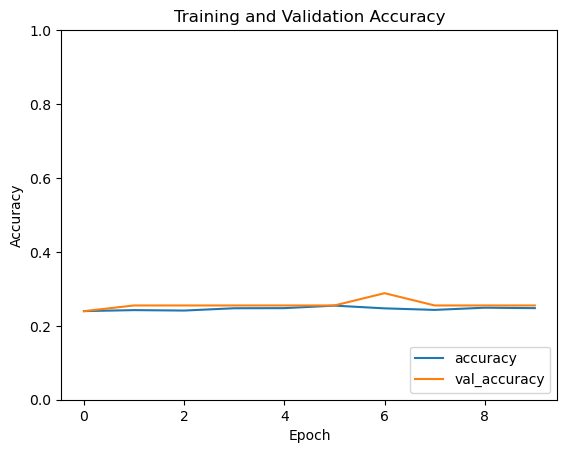

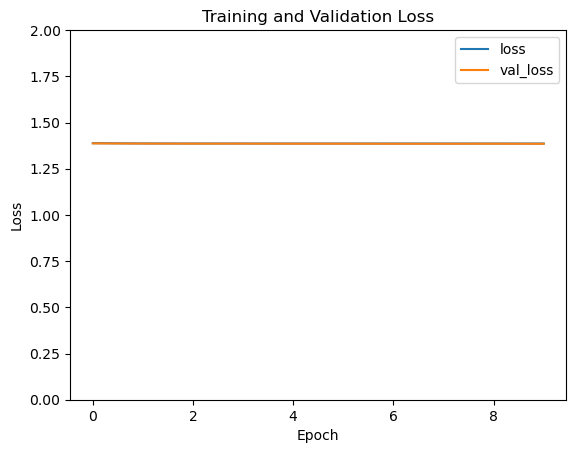

1/1 [==============================] - 1s 905ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


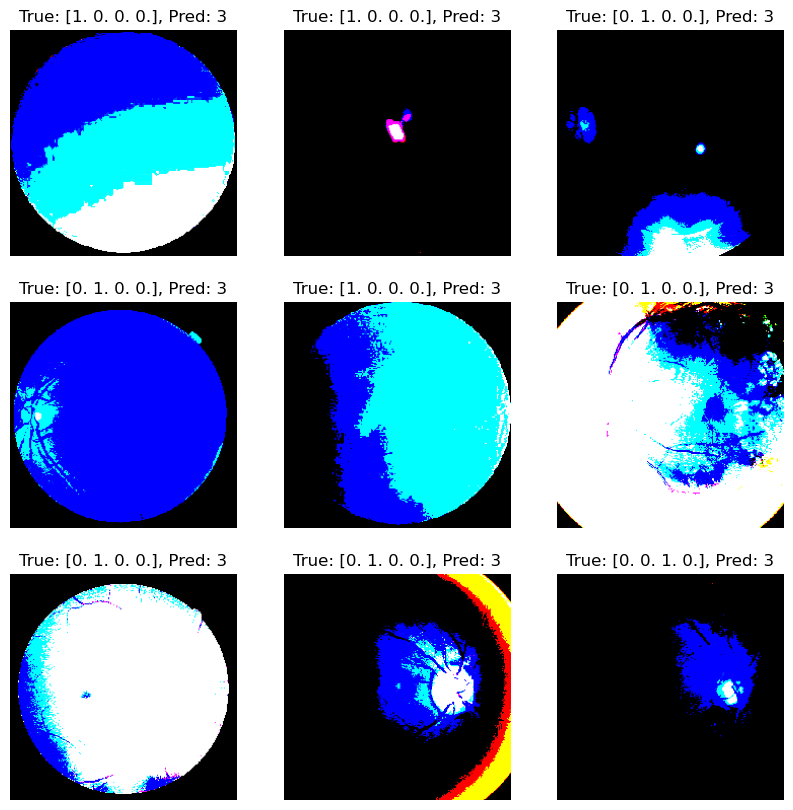

In [58]:
import matplotlib.pyplot as plt

# График точности
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

# График потерь
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Визуализация некоторых изображений и соответствующих предсказаний
import numpy as np

def plot_images(images, labels_true, labels_pred=None):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        if labels_pred is not None:
            plt.title("True: {}, Pred: {}".format(labels_true[i], labels_pred[i]))
        else:
            plt.title("True: {}".format(labels_true[i]))
        plt.axis("off")
    plt.show()

# Получаем несколько изображений и их предсказания
sample_images, true_labels = next(test_data)
predicted_labels = np.argmax(model.predict(sample_images), axis=1)

# Визуализируем изображения
plot_images(sample_images, true_labels, predicted_labels)


# VGG-16

In [48]:
from tensorflow.keras import layers, models

num_classes = 4  # Замените на нужное количество классов
# Создаем модель VGG16
model = models.Sequential()

# Первый сверточный блок
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

# Второй сверточный блок
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

# Третий сверточный блок
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

# Четвертый сверточный блок
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

# Пятый сверточный блок
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

# Преобразуем в одномерный массив
model.add(layers.Flatten())

# Полносвязные слои
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))

# Выходной слой для классификации
model.add(layers.Dense(num_classes, activation='softmax'))

# Компилируем модель
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

In [49]:
# Обучаем модель
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=10
)

# Оценка модели на тестовых данных
test_loss, test_acc = model.evaluate(test_data)
print('Test accuracy:', test_acc)

# Генерация предсказаний для тестовых данных
predictions = model.predict(test_data)


Epoch 1/10
106/106 [==============================] - 1335s 13s/step - loss: 9.4289 - accuracy: 0.2676 - val_loss: 1.3859 - val_accuracy: 0.2883
Epoch 2/10
106/106 [==============================] - 1362s 13s/step - loss: 1.3999 - accuracy: 0.2623 - val_loss: 1.3732 - val_accuracy: 0.2989
Epoch 3/10
106/106 [==============================] - 1376s 13s/step - loss: 1.3883 - accuracy: 0.2525 - val_loss: 1.3861 - val_accuracy: 0.2883
Epoch 4/10
106/106 [==============================] - 1398s 13s/step - loss: 1.3864 - accuracy: 0.2472 - val_loss: 1.3852 - val_accuracy: 0.2883
Epoch 5/10
106/106 [==============================] - 1412s 13s/step - loss: 1.3865 - accuracy: 0.2596 - val_loss: 1.3856 - val_accuracy: 0.2550
Epoch 6/10
106/106 [==============================] - 1395s 13s/step - loss: 1.3865 - accuracy: 0.2513 - val_loss: 1.3853 - val_accuracy: 0.2883
Epoch 7/10
106/106 [==============================] - 1313s 12s/step - loss: 1.3864 - accuracy: 0.2481 - val_loss: 1.3853 - val_ac

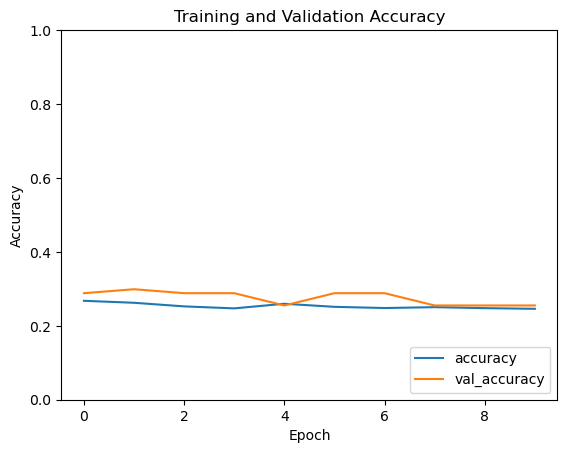

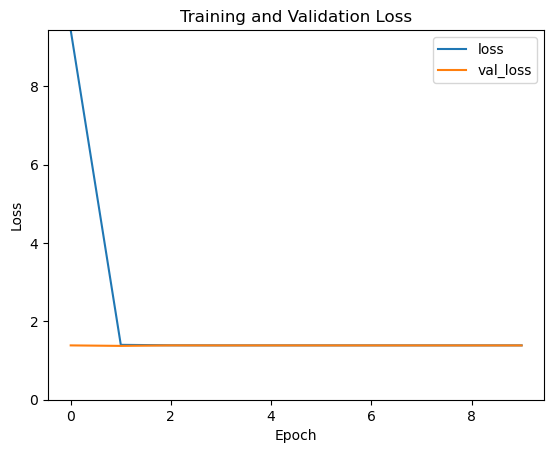

In [50]:
import matplotlib.pyplot as plt

# График точности
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

# График потерь
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, max(history.history['loss'] + history.history['val_loss'])])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
